In [1]:
import os
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
import joblib
from sklearn.model_selection import GridSearchCV
import cv2
import seaborn as sns
import time
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [2]:
folder_path = f"E:\\ML Intern\\task 3 csv files"
os.makedirs(folder_path, exist_ok=True)

# define path
confusion_image_path = os.path.join(folder_path, 'confusion matrix.png')
classification_file_path = os.path.join(folder_path, 'classification_report.txt')
model_file_path = os.path.join(folder_path, "svm_model.pkl")

# Path dataset
dataset_dir = "E:\\ML Intern\\task 3 csv files"
train_dir = os.path.join(dataset_dir, "train")
test_dir = os.path.join(dataset_dir, "test1")

In [3]:
# load data, preprocessing data, and labeling
# dog = 1, cat = 0
train_images = os.listdir(train_dir)
features = []
labels = []
image_size = (50, 50)

# Process train images
for image in tqdm(train_images, desc="Processing Train Images"):
    if image[0:3] == 'cat' :
        label = 0
    else :
        label = 1
    image_read = cv2.imread(train_dir+"/"+image)
    image_resized = cv2.resize(image_read, image_size)
    image_normalized = image_resized / 255.0
    image_flatten = image_normalized.flatten()
    features.append(image_flatten)
    labels.append(label)

Processing Train Images: 100%|█████████████████████████████████████████████████████| 1002/1002 [00:25<00:00, 39.16it/s]


In [4]:
del train_images

In [5]:
features = np.asarray(features)
labels = np.asarray(labels)

# train test split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, shuffle=True, random_state=42)

In [6]:
del features
del labels

In [7]:
# PCA, SVM, & Pipeline
n_components = 0.8
pca = PCA(n_components=n_components)
svm = SVC()
pca = PCA(n_components=n_components, random_state=42)
pipeline = Pipeline([
    ('pca', pca),
    ('svm', svm)
])

In [8]:
param_grid = {
    'pca__n_components': [2, 1, 0.9, 0.8],
    'svm__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
}

In [9]:
# Calculate training time
start_time = time.time()

grid_search = GridSearchCV(pipeline, param_grid, cv=3, verbose=4)
grid_search.fit(X_train, y_train)
end_time = time.time()

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 1/3] END pca__n_components=2, svm__kernel=linear;, score=0.483 total time=   0.5s
[CV 2/3] END pca__n_components=2, svm__kernel=linear;, score=0.506 total time=   0.4s
[CV 3/3] END pca__n_components=2, svm__kernel=linear;, score=0.479 total time=   0.4s
[CV 1/3] END pca__n_components=2, svm__kernel=rbf;, score=0.607 total time=   0.4s
[CV 2/3] END pca__n_components=2, svm__kernel=rbf;, score=0.536 total time=   0.3s
[CV 3/3] END pca__n_components=2, svm__kernel=rbf;, score=0.509 total time=   0.3s
[CV 1/3] END pca__n_components=2, svm__kernel=poly;, score=0.502 total time=   0.2s
[CV 2/3] END pca__n_components=2, svm__kernel=poly;, score=0.502 total time=   0.3s
[CV 3/3] END pca__n_components=2, svm__kernel=poly;, score=0.491 total time=   0.3s
[CV 1/3] END pca__n_components=2, svm__kernel=sigmoid;, score=0.483 total time=   0.3s
[CV 2/3] END pca__n_components=2, svm__kernel=sigmoid;, score=0.494 total time=   0.3s
[CV 3/

In [10]:
del X_train
del y_train

In [11]:
# Obtaining the best model and the best parameters
best_pipeline = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters: ", best_params)
print("Best Score: ", best_score)

Best Parameters:  {'pca__n_components': 0.9, 'svm__kernel': 'rbf'}
Best Score:  0.5630461922596754


In [12]:
# Evaluation on test dataset
accuracy = best_pipeline.score(X_test, y_test)
print("Accuracy:", accuracy)

Accuracy: 0.6318407960199005


In [13]:
y_pred = best_pipeline.predict(X_test)

# classification report
target_names = ['Cat', 'Dog']
classification_rep = classification_report(y_test, y_pred, target_names=target_names)
print("Classification Report:\n", classification_rep)

with open(classification_file_path, 'w') as file:
    file.write(classification_rep)

Classification Report:
               precision    recall  f1-score   support

         Cat       0.62      0.63      0.62        97
         Dog       0.65      0.63      0.64       104

    accuracy                           0.63       201
   macro avg       0.63      0.63      0.63       201
weighted avg       0.63      0.63      0.63       201



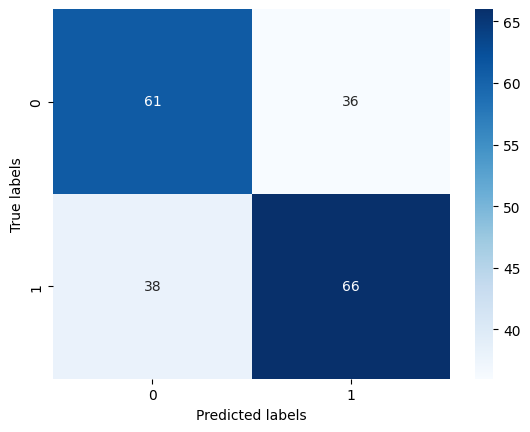

In [14]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.savefig(confusion_image_path)
plt.show()